In [2]:
import struct
import random
import array

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
#if struct.pack("H", 1) == b"\x00\x01":  # big endian
#    checksum_endian_transform = lambda chk: chk  # type: Callable[[int], int]
#else:
#    checksum_endian_transform = lambda chk: ((chk >> 8) & 0xff) | chk << 8

def calc_crc(data, offset=0, start=0):
    if len(data) % 2 == 1:
        data += b"\0"

    s = start
    s += sum(array.array("H", data))
    s = (s >> 16) + (s & 0xffff)
    s += s >> 16
    s = ~s
    return s & 0xffff
#    self.crc = checksum_endian_transform(s) & 0xffff

In [4]:
class Stream:
    def __init__(self):
        self.src = random.randrange(0, 2**32)
        self.sport = random.randrange(0, 2**16)
        self.dst = random.randrange(0, 2**32)
        self.dport = random.randrange(0, 2**16)
    def __str__(self):
        return f"{self.src}:{self.sport} ==> {self.dst}:{self.dport}"

class Packet:
    def __init__(self, pair, length, data_rng):
        self.pair = pair
        self.length = length
        
        # generate data and compute CRC
        ip_header = struct.pack('!IIBBH', self.pair.src, self.pair.dst, 0, 6, self.length + 20)
        tcp_header = struct.pack('!HH4I', self.pair.sport, self.pair.dport, 0, 0, 0, 0)
        payload = struct.pack(f'{self.length}B', *(data_rng.randrange(0, 256) for _ in range(self.length)))

        pkt = ip_header + tcp_header + payload
        self.crc = calc_crc(pkt)

In [5]:
points = 10
pair1 = Stream()
pair2 = Stream()
print(pair1)
print(pair2)

data_seed = 0
data_rng = random.Random(data_seed)

stream1 = [Packet(pair1, data_rng.randrange(0, 1400), data_rng) for _ in range(points)]
data_rng.seed(data_seed)
stream2 = [Packet(pair2, data_rng.randrange(0, 1400), data_rng) for _ in range(points)]

df = pd.DataFrame({
    'len': [p.length for p in stream1],
    'crc1': [p.crc for p in stream1],
    'crc2': [p.crc for p in stream2],
})

df['diff'] = df['crc2'] - df['crc1']

print()
print(df)

322443645:58713 ==> 722454829:65487
1340594957:4701 ==> 2253604467:60209

    len   crc1   crc2   diff
0   788  61023  49008 -12015
1   166  59455  47440 -12015
2   771  54902  42887 -12015
3   858   4833  58353  53520
4  1340  43496  31481 -12015
5   435  13716   1701 -12015
6   121  31033  19018 -12015
7   674  60505  48490 -12015
8   368  14110   2095 -12015
9    56  56316  44301 -12015


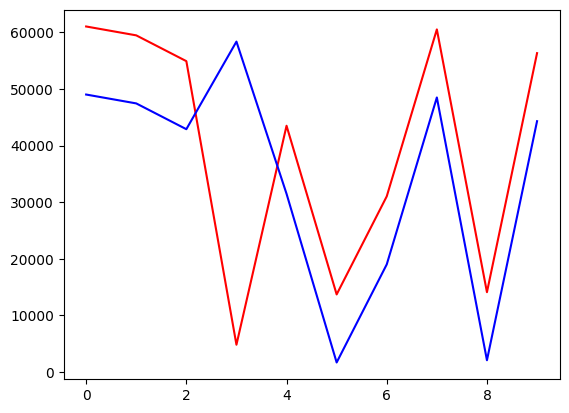

In [6]:
x = np.linspace(0, points-1, points)

plt.plot(x, df['crc1'], 'r')
plt.plot(x, df['crc2'], 'b')
plt.show()

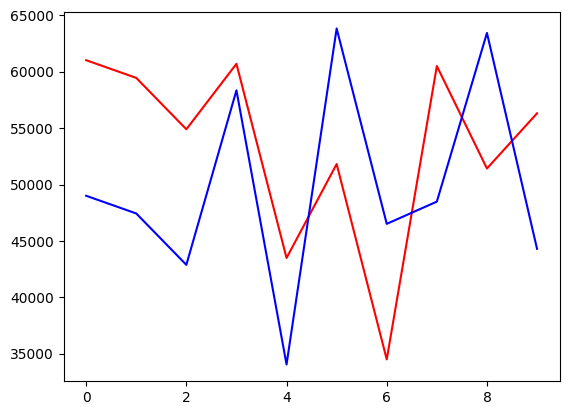

In [10]:
plt.plot(x, np.where((df.crc1 < 2**15), 2**16 - df.crc1, df.crc1), 'r')
plt.plot(x, np.where((df.crc2 < 2**15), 2**16 - df.crc2, df.crc2), 'b')
plt.show()

In [11]:
df['crc2+'] = np.where(df['crc2'] < df['crc1'], df['crc2'] + 2**16-1, df['crc2'])
df['diff+'] = df['crc2+'] - df['crc1']
df

,len,crc1,crc2,diff,crc2+,diff+
0,788,61023,49008,-12015,114543,53520
1,166,59455,47440,-12015,112975,53520
2,771,54902,42887,-12015,108422,53520
3,858,4833,58353,53520,58353,53520
4,1340,43496,31481,-12015,97016,53520
5,435,13716,1701,-12015,67236,53520
6,121,31033,19018,-12015,84553,53520
7,674,60505,48490,-12015,114025,53520
8,368,14110,2095,-12015,67630,53520
9,56,56316,44301,-12015,109836,53520


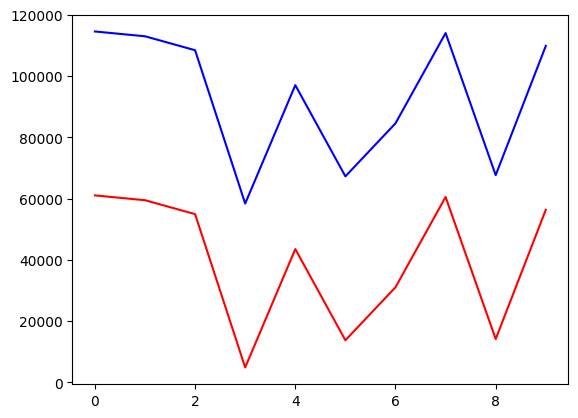

In [12]:
plt.plot(x, df['crc1'], 'r')
plt.plot(x, df['crc2+'], 'b')
plt.show()

In [17]:
import math
def sub_crc(crc, data, offset=0):
    if offset % 2 == 1:
        data = b"\0" + data
    if len(data) % 2 == 1:
        data += b"\0"
    
    crc = ~crc
    crc &= 0xffff
    s = sum(array.array("H", data))
    correction = math.floor(abs(crc - s) / (2**16))
    crc -= s
    crc -= correction
    crc = ~crc
    return crc & 0xffff

def remove_addr_from_crc(crc, src, sport, dst, dport):
    data_to_remove = struct.pack('!IIHH', src, dst, sport, dport)
    return sub_crc(crc, data_to_remove)

df['sub1'] = df['crc1'].apply(lambda x: remove_addr_from_crc(x, pair1.src, pair1.sport, pair1.dst, pair1.dport))
df['sub2'] = df['crc2'].apply(lambda x: remove_addr_from_crc(x, pair2.src, pair2.sport, pair2.dst, pair2.dport))
df

,len,crc1,crc2,diff,crc2+,diff+,sub1,sub2
0,788,61023,49008,-12015,114543,53520,2661,2661
1,166,59455,47440,-12015,112975,53520,1093,1093
2,771,54902,42887,-12015,108422,53520,62075,62075
3,858,4833,58353,53520,58353,53520,12006,12006
4,1340,43496,31481,-12015,97016,53520,50669,50669
5,435,13716,1701,-12015,67236,53520,20889,20889
6,121,31033,19018,-12015,84553,53520,38206,38206
7,674,60505,48490,-12015,114025,53520,2143,2143
8,368,14110,2095,-12015,67630,53520,21283,21283
9,56,56316,44301,-12015,109836,53520,63489,63489


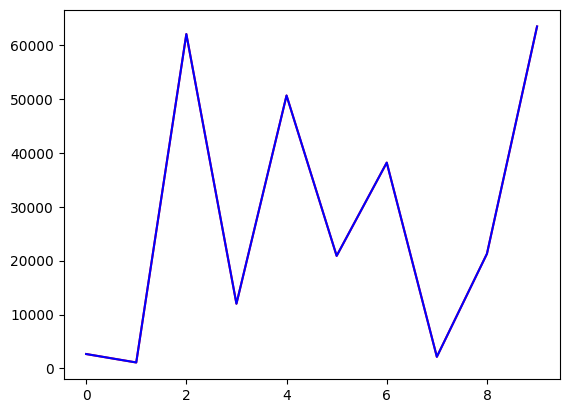

In [18]:
plt.plot(x, df['sub1'], 'r')
plt.plot(x, df['sub2'], 'b')
plt.show()

In [134]:
from scipy.fft import fft, ifft

wave1 = fft(df['crc1'])
wave2 = fft(df['crc2+'])

df_wave = pd.DataFrame({
    'r1': [e.real for e in wave1],
    'i1': [e.imag for e in wave1],
    'r2': [e.real for e in wave2],
    'i2': [e.imag for e in wave2],
})

df_wave

,r1,i1,r2,i2
0,314609.000000,-0.000000,540159.000000,-0.000000
1,-36746.121407,43501.601965,-36746.121407,43501.601965
2,4602.072109,-33118.941397,4602.072109,-33118.941397
3,-13693.378593,38742.860474,-13693.378593,38742.860474
4,15318.427891,-65952.258620,15318.427891,-65952.258620
5,9739.000000,-0.000000,9739.000000,-0.000000
6,15318.427891,65952.258620,15318.427891,65952.258620
7,-13693.378593,-38742.860474,-13693.378593,-38742.860474
8,4602.072109,33118.941397,4602.072109,33118.941397
9,-36746.121407,-43501.601965,-36746.121407,-43501.601965


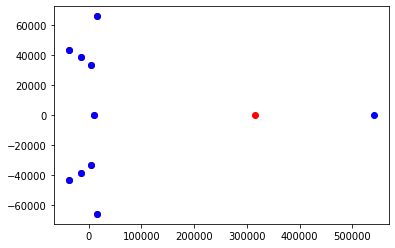

In [135]:
plt.scatter(df_wave['r1'], df_wave['i1'], c='r')
plt.scatter(df_wave['r2'], df_wave['i2'], c='b')
plt.show()

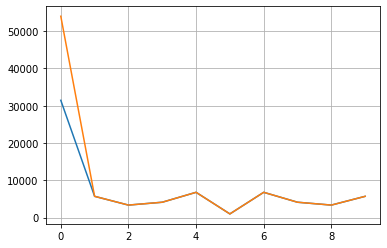

In [136]:
from scipy.fft import fftfreq

N = 20
T = 1.0/N
x = np.linspace(0.0, N*T, N, endpoint=False)
xf = fftfreq(N, T)[:N//2]
for yf in wave1, wave2:
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()